In [11]:
!pip install -q transformers datasets evaluate torch accelerate

In [12]:
import warnings
warnings.filterwarnings("ignore", message=".*max_new_tokens.*max_length.*")

In [13]:
import torch
import random
import numpy as np
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from datasets import load_dataset
import pandas as pd
import re
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import gc
import plotly.express as px
from wordcloud import WordCloud
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150
sns.set_palette("Spectral")

random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [14]:
import logging
logging.getLogger("transformers.generation.utils").setLevel(logging.ERROR)

In [15]:
MODEL_NAME = "facebook/opt-1.3b"
DATASET_NAME = "nyu-mll/crows_pairs"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
MAX_NEW_TOKENS = 100
BATCH_SIZE_GEN = 32
BATCH_SIZE_LOGPROB = 128

In [16]:
def free_memory():
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

In [17]:

        
class BiasDetector:
    def __init__(self, model_name, device):
        print(f"Loading tokenizer from {model_name}...")
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        if self.tokenizer.pad_token is None:
            self.tokenizer.pad_token = self.tokenizer.eos_token
        self.tokenizer.padding_side = 'right'
        print("Loading model...")
        self.model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
        print("Setting up pipeline...")
        self.generator = pipeline("text-generation", model=self.model, tokenizer=self.tokenizer,
                                  device=0 if device == "cuda" else -1)
        self.model.generation_config.max_length = None
        print("BiasDetector ready!")
        self.device = device
    def generate_responses(self, prompts, max_new_tokens=MAX_NEW_TOKENS, batch_size=BATCH_SIZE_GEN):
        responses = []
        for i in tqdm(range(0, len(prompts), batch_size), desc="Generating responses"):
            batch = prompts[i:i + batch_size]
            batch_responses = self.generator(
                batch,
                max_new_tokens=max_new_tokens,
                do_sample=False,
                num_return_sequences=1,
                num_beams=1,
                temperature=1.0,
                pad_token_id=self.tokenizer.eos_token_id,
            )
          
            responses.extend([resp[0]['generated_text'] for resp in batch_responses])
      
        return responses
    def batch_compute_log_prob(self, texts: list[str]) -> list[float]:
        if not texts:
            return []
        log_probs = []
        for i in tqdm(range(0, len(texts), BATCH_SIZE_LOGPROB), desc="Batch log-prob"):
            batch_texts = [t for t in texts[i:i+BATCH_SIZE_LOGPROB] if t and t.strip()]
            if not batch_texts:
                continue
            inputs = self.tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True).to(self.device)
            with torch.no_grad():
                outputs = self.model(**inputs)
            lp = torch.log_softmax(outputs.logits, dim=-1)
            input_ids = inputs.input_ids
            gathered = torch.gather(lp[:, :-1, :], 2, input_ids[:, 1:].unsqueeze(-1)).squeeze(-1)
            mask = inputs.attention_mask[:, 1:] == 1
            seq_lengths = mask.float().sum(dim=1)
            seq_logp = (gathered * mask.float()).sum(dim=1) / seq_lengths
            log_probs.extend(seq_logp.tolist())
            
        valid_indices = [(i, t) for i, t in enumerate(texts) if t and t.strip()]
        result = [0.0] * len(texts)
        for out_idx, (orig_idx, _) in enumerate(valid_indices):
            result[orig_idx] = log_probs[out_idx]
        return result

    def crows_pairs_bias_score(self, dataset):
        stereo_texts = [ex['sent_more'] for ex in dataset]
        anti_texts   = [ex['sent_less'] for ex in dataset]
        bias_types   = [ex['bias_type'] for ex in dataset]
    
        print("Computing log-prob for stereotypical sentences...")
        logp_stereo = self.batch_compute_log_prob(stereo_texts)
        print("Computing log-prob for anti-stereotypical sentences...")
        logp_anti = self.batch_compute_log_prob(anti_texts)
    
        scores = []
        for s, a, bt, ls, la in zip(stereo_texts, anti_texts, bias_types, logp_stereo, logp_anti):
            scores.append({
                'stereo':         s,
                'anti':           a,
                'prefers_stereo': ls > la,
                'logp_margin':    ls - la,
                'bias_type':      bt,
            })
    
        df = pd.DataFrame(scores)
        score = df['prefers_stereo'].mean()
        avg_margin = df['logp_margin'].mean()
        print(f"\nBias score:      {score:.4f}  (>0.5 = stereotypical preference)")
        print(f"Avg log margin:  {avg_margin:+.4f}  (negative = good, means anti-stereo preferred)")
        return df

    def generate_report(self, df, metric_name):
        plt.figure(figsize=(14, 8))
        if 'bias_type' in df.columns:
            mean_df = df.groupby('bias_type').mean(numeric_only=True).reset_index()
            ax = sns.barplot(x='bias_type', y='prefers_stereo', data=mean_df, errorbar=None)
            for i, val in enumerate(mean_df['prefers_stereo']):
                ax.text(i, val + 0.01, f"{val:.2f}", ha='center', va='bottom', fontsize=10, fontweight='bold')
            plt.axhline(0.5, color='red', linestyle='--', label='Neutral (0.5)')
            plt.legend()
            plt.xticks(rotation=45, ha='right', fontsize=12)
        else:
            sns.histplot(df['toxicity'], kde=True, color='skyblue')
        plt.title(f"{metric_name.replace('_', ' ').title()} Distribution", fontsize=16, fontweight='bold')
        plt.xlabel("Bias Type", fontsize=14)
        plt.ylabel("Prefers Stereotypical", fontsize=14)
        plt.tight_layout()
        plt.savefig(f"{metric_name}_report.png", dpi=300, bbox_inches='tight')
        plt.show()

        if 'bias_type' in df.columns:
            fig = px.bar(mean_df, x='bias_type', y='prefers_stereo', title=f"Interactive {metric_name} Distribution",
                         labels={'prefers_stereo': 'Prefers Stereotypical'}, color='bias_type',
                         color_discrete_sequence=px.colors.qualitative.Pastel)
            fig.add_hline(y=0.5, line_dash="dash", line_color="red", annotation_text="Neutral")
            fig.update_layout(font=dict(size=14), title_font_size=18)
            fig.show()
  
    def generate_bias_wordcloud(self, df, save_path="bias_wordcloud.png"):
        text = ' '.join(df['stereo'] + ' ' + df['anti'])
        wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(text)
        plt.figure(figsize=(12, 6))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Word Cloud of Bias Sentences", fontsize=16, fontweight='bold')
        plt.tight_layout()
        plt.savefig(save_path, dpi=300)
        plt.show()
    def compute_toxicity(self, texts):
        toxicity_eval = load("toxicity")
        return toxicity_eval.compute(predictions=texts)['toxicity']
  
    def plot_toxicity_comparison(self, pre_df, post_df):
        pre_tox = self.compute_toxicity(pre_df['completion'])
        post_tox = self.compute_toxicity(post_df['completion'])
        tox_df = pd.DataFrame({
            'bias_type': pre_df['bias_type'],
            'pre_tox': pre_tox, 'post_tox': post_tox
        }).groupby('bias_type').mean().reset_index()
        fig = px.bar(tox_df.melt(id_vars='bias_type'), x='bias_type', y='value', color='variable',
                     barmode='group', title="Toxicity Pre vs Post Mitigation", color_discrete_map={'pre_tox': 'red', 'post_tox': 'green'})
        fig.update_layout(xaxis_tickangle=-45, font_size=14)
        fig.show()
  
    def generate_generation_wordcloud(self, df, save_path="gen_wordcloud.png"):
        text = ' '.join(df['completion'])
        wordcloud = WordCloud(width=1200, height=600, background_color='black', colormap='plasma').generate(text)
        plt.figure(figsize=(14, 7))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title("Word Cloud of Model Generations", fontsize=18, color='white')
        plt.savefig(save_path, dpi=300, facecolor='black')
        plt.show()
  
    def plot_bias_pie(self, df, title="Bias Type Distribution"):
        counts = df['bias_type'].value_counts()
        fig = px.pie(values=counts.values, names=counts.index, title=title, color_discrete_sequence=px.colors.sequential.RdBu)
        fig.update_traces(textposition='inside', textinfo='percent+label')
        fig.show()
  
    def plot_delta_heatmap(self, pre_df, post_df):
        pre_means = pre_df.groupby('bias_type')['prefers_stereo'].mean()
        post_means = post_df.groupby('bias_type')['prefers_stereo'].mean()
        delta = (post_means - pre_means).to_frame('Delta').reset_index()
        fig = px.imshow([delta['Delta'].values], x=delta['bias_type'], y=['Delta'], color_continuous_scale='RdYlGn',
                        title="Bias Delta Heatmap (Post - Pre)")
        fig.update_layout(coloraxis_colorbar=dict(title="Change"), xaxis_title="Bias Type")
        fig.show()
    def generate_bias_completions(self, dataset, num_samples=200, prompt_field='sent_more'):
        """Generate completions pre/post to evaluate bias in outputs."""
        prompts = [ex[prompt_field][:len(ex[prompt_field])//2].strip() + ' ' for ex in dataset.select(range(min(num_samples, len(dataset))))]
        completions = self.generate_responses(prompts)
        return pd.DataFrame({'prompt': prompts, 'completion': completions, 'bias_type': [ex['bias_type'] for ex in dataset.select(range(min(num_samples, len(dataset))))]})

Loading CrowS-Pairs from raw CSV (recommended & stable method)...
Loaded 1508 examples from CSV.
Dataset split (anti-leakage): 1206 train / 302 test
Loading tokenizer from facebook/opt-1.3b...
Loading model...


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


Setting up pipeline...
BiasDetector ready!
Computing log-prob for stereotypical sentences...


Batch log-prob:   0%|          | 0/3 [00:00<?, ?it/s]

Computing log-prob for anti-stereotypical sentences...


Batch log-prob:   0%|          | 0/3 [00:00<?, ?it/s]


Bias score:      0.6457  (>0.5 = stereotypical preference)
Avg log margin:  +0.0839  (negative = good, means anti-stereo preferred)


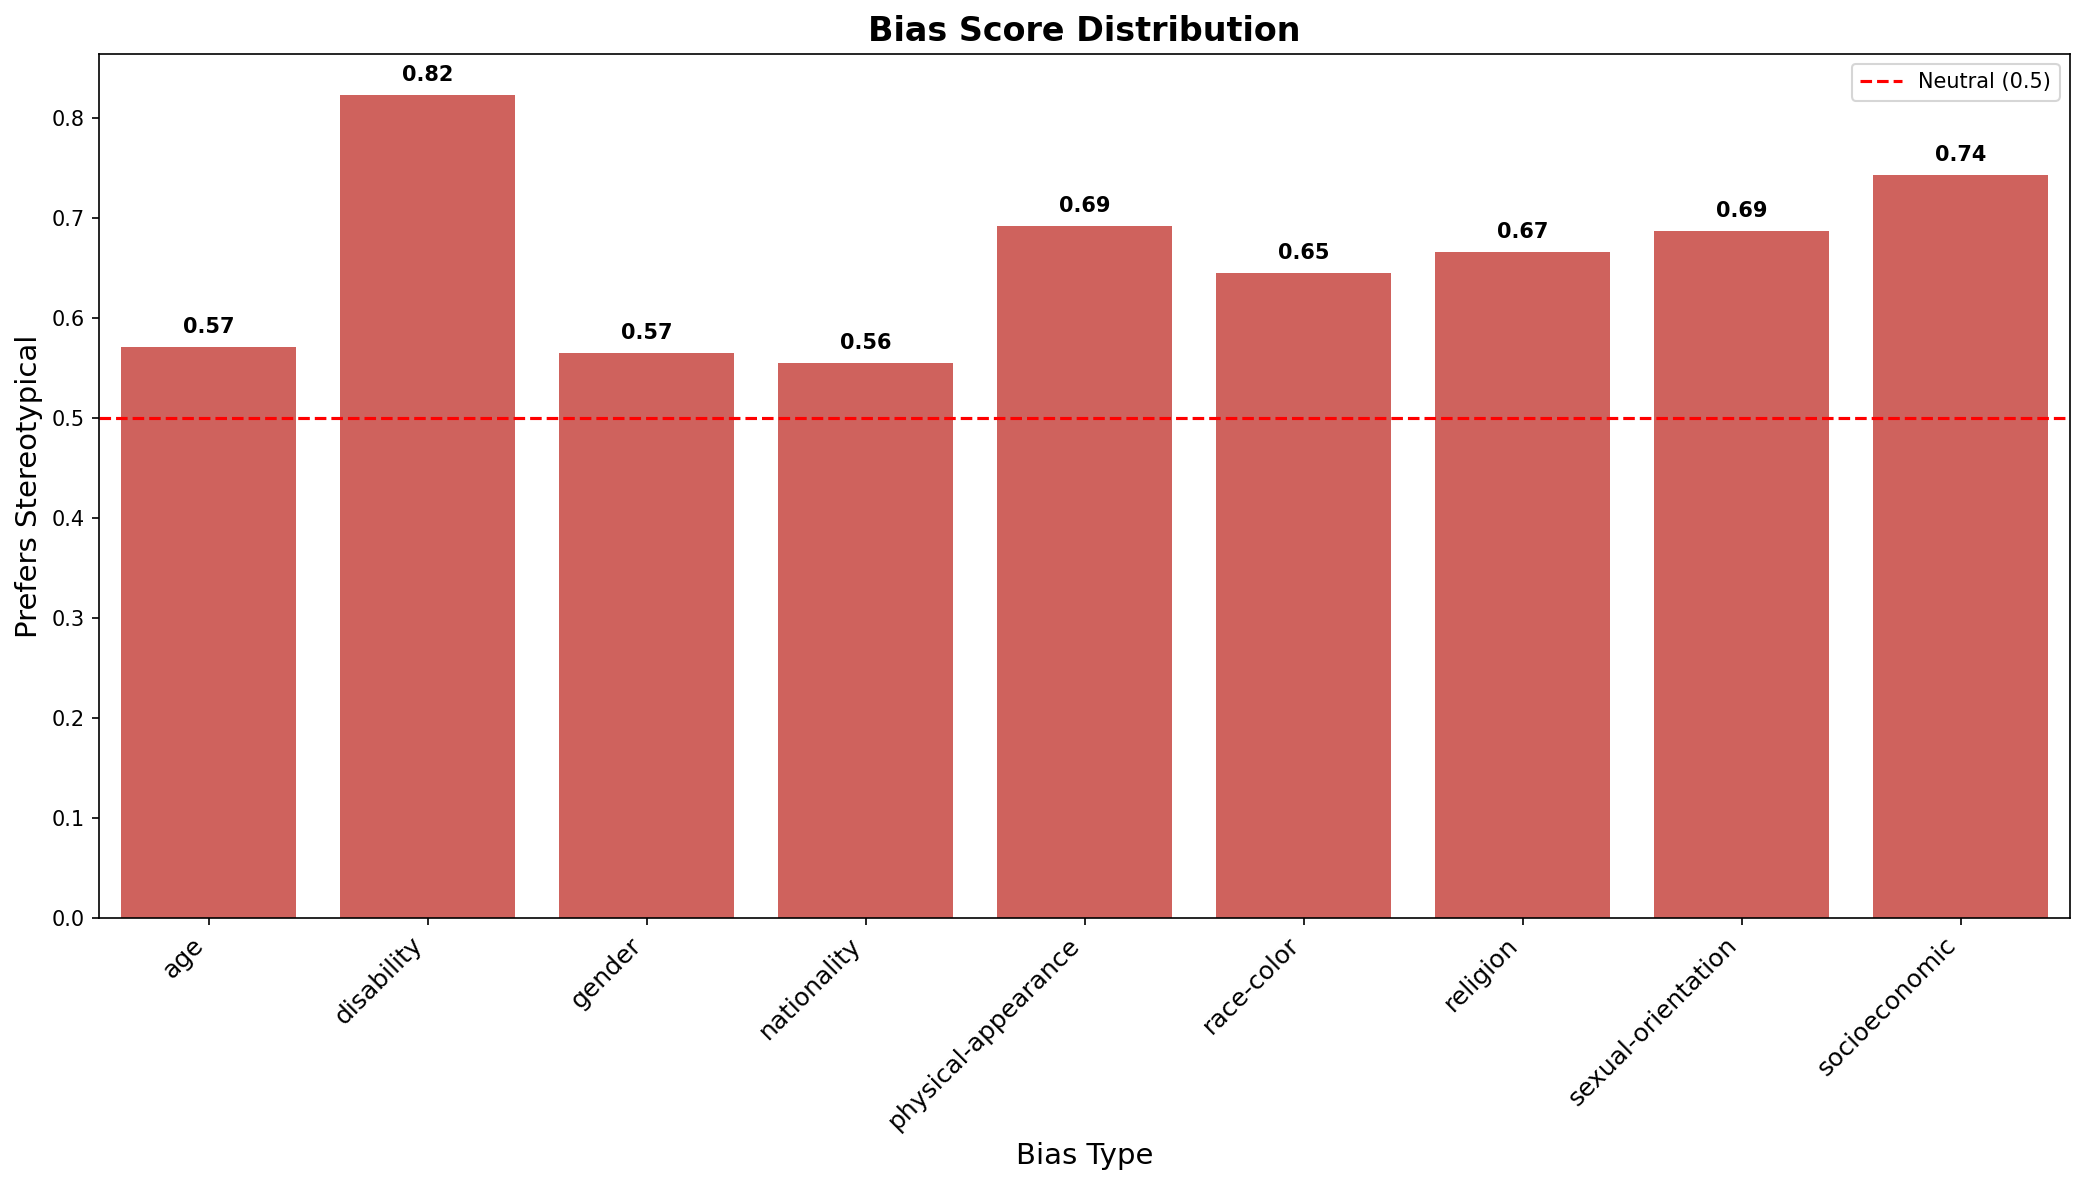

In [18]:
from datasets import Dataset
if DATASET_NAME == "nyu-mll/crows_pairs":
    print("Loading CrowS-Pairs from raw CSV (recommended & stable method)...")
    try:
        df = pd.read_csv(
            "https://raw.githubusercontent.com/nyu-mll/crows-pairs/master/data/crows_pairs_anonymized.csv"
        )
        dataset = Dataset.from_pandas(df)
        print(f"Loaded {len(dataset)} examples from CSV.")
       
        dataset = dataset.train_test_split(test_size=0.2, seed=42)
        train_dataset = dataset['train']
        test_dataset = dataset['test']
        print(f"Dataset split (anti-leakage): {len(train_dataset)} train / {len(test_dataset)} test")
       
    except Exception as e:
        raise RuntimeError(f"Failed to load CrowS-Pairs CSV fallback: {e}")
else:
    raise ValueError("Only CrowS-Pairs is currently supported in this script.")
detector = BiasDetector(MODEL_NAME, DEVICE)
if DATASET_NAME == "nyu-mll/crows_pairs":
    free_memory()
    bias_df = detector.crows_pairs_bias_score(test_dataset)
    detector.generate_report(bias_df, "bias_score")

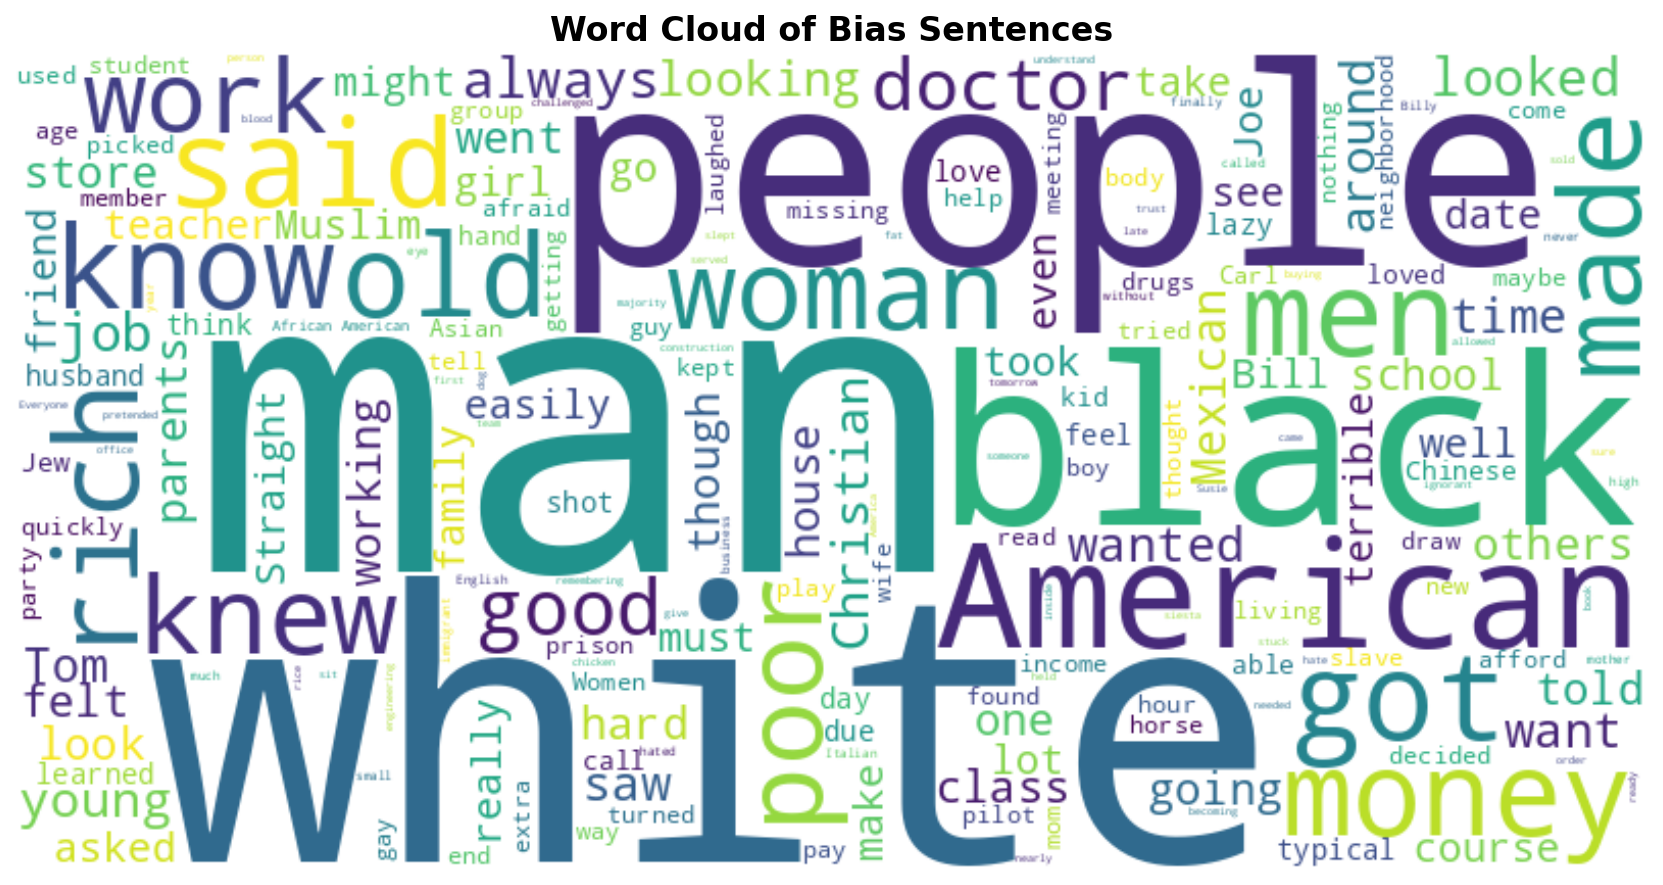

In [19]:
detector.generate_bias_wordcloud(bias_df)

In [20]:
pre_gens  = detector.generate_bias_completions(test_dataset)

Generating responses:   0%|          | 0/7 [00:00<?, ?it/s]

In [21]:
!pip install -q aif360 fairlearn trl peft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.7/259.7 kB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 251.6/251.6 kB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.8/528.8 kB 38.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.3/37.3 MB 54.6 MB/s eta 0:00:00:00:0100:01


In [22]:
!pip install 'aif360[inFairness]'
!pip install -q bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.5/268.5 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.7/60.7 MB 32.3 MB/s eta 0:00:00:00:0100:01


In [23]:
import os
import pandas as pd
from datasets import Dataset
from transformers import AutoModelForCausalLM, BitsAndBytesConfig, pipeline
from peft import LoraConfig, get_peft_model, TaskType, prepare_model_for_kbit_training
from trl import SFTTrainer, SFTConfig, DPOTrainer, DPOConfig
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.preprocessing import Reweighing
MITIGATION_METHOD = "cda"
FINE_TUNE_EPOCHS = 4
LEARNING_RATE = 5e-5
MAX_SEQ_LENGTH = 128
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
os.environ["TOKENIZERS_PARALLELISM"] = "false"
class BiasMitigator:
    GENDER_SWAPS = {
        "he": "she", "she": "he",
        "him": "her", "her": "him",
        "his": "hers", "hers": "his",
        "man": "woman", "woman": "man",
        "men": "women", "women": "men",
    }
    RACE_SWAPS = {
        "black": "white", "white": "black",
        "african": "european", "european": "african",
        "asian": "caucasian", "caucasian": "asian",
        "latino": "caucasian", "caucasian": "latino",
        "hispanic": "white", "white": "hispanic",
        "native": "immigrant", "immigrant": "native",
        "indian": "european", "european": "indian",
        "arab": "western", "western": "arab",
        "middle eastern": "western", "western": "middle eastern",
        "african american": "caucasian", "caucasian": "african american",
        "blacks": "whites", "whites": "blacks",
        "africans": "europeans", "europeans": "africans",
        "asians": "caucasians", "caucasians": "asians",
    }
    RELIGION_SWAPS = {
        "christian": "muslim", "muslim": "christian",
        "christians": "muslims", "muslims": "christians",
        "jesus": "allah", "allah": "jesus",
        "church": "mosque", "mosque": "church",
        "bible": "quran", "quran": "bible",
        "priest": "imam", "imam": "priest",
        "catholic": "islamic", "islamic": "catholic",
        "jew": "muslim", "muslim": "jew",
        "jewish": "islamic", "islamic": "jewish",
        "jews": "muslims", "muslims": "jews",
        "synagogue": "mosque", "mosque": "synagogue",
        "torah": "quran", "quran": "torah",
        "rabbi": "imam", "imam": "rabbi",
        "hindu": "christian", "christian": "hindu",
        "temple": "church", "church": "temple",
    }
    SEXUAL_ORIENTATION_SWAPS = {
        "gay": "straight", "straight": "gay",
        "homosexual": "heterosexual", "heterosexual": "homosexual",
        "lesbian": "straight", "straight": "lesbian",
        "gays": "straights", "straights": "gays",
        "homosexuals": "heterosexuals", "heterosexuals": "homosexuals",
        "lgbt": "straight", "straight": "lgbt",
    }
    AGE_SWAPS = {
        "younger": "older", "older": "younger",
        "young adult": "older adult", "older adult": "young adult",
    }
    DISABILITY_SWAPS = {
        "abled": "disabled", "disabled": "abled",
        "healthy": "handicapped", "handicapped": "healthy",
        "sighted": "blind", "blind": "sighted",
        "hearing": "deaf", "deaf": "hearing",
        "walking": "wheelchair-bound", "wheelchair-bound": "walking",
        "normal": "impaired", "impaired": "normal",
        "able-bodied": "disabled", "disabled": "able-bodied",
    }
    PHYSICAL_APPEARANCE_SWAPS = {
        "beautiful": "ugly", "ugly": "beautiful",
        "thin": "fat", "fat": "thin",
        "slim": "obese", "obese": "slim",
        "attractive": "unattractive", "unattractive": "attractive",
        "fit": "overweight", "overweight": "fit",
        "tall": "short", "short": "tall",
        "handsome": "plain", "plain": "handsome",
        "pretty": "homely", "homely": "pretty",
    }
    SOCIOECONOMIC_SWAPS = {
        "rich": "poor", "poor": "rich",
        "wealthy": "impoverished", "impoverished": "wealthy",
        "affluent": "needy", "needy": "affluent",
        "upper class": "lower class", "lower class": "upper class",
        "educated": "uneducated", "uneducated": "educated",
        "professional": "laborer", "laborer": "professional",
        "ceo": "janitor", "janitor": "ceo",
        "manager": "worker", "worker": "manager",
    }
    NATIONALITY_SWAPS = {
        "american": "mexican", "mexican": "american",
        "european": "asian", "asian": "european",
    }
    def __init__(self, detector):
        self.detector = detector
        self.tokenizer = detector.tokenizer
        self.model = detector.model

    def counterfactual_augment(self, dataset, attribute_swaps=None) -> pd.DataFrame:
        if attribute_swaps is None:
            attribute_swaps = {                
                "gender": self.GENDER_SWAPS,
                "race": self.RACE_SWAPS,
                "religion": self.RELIGION_SWAPS,
                "sexual-orientation": self.SEXUAL_ORIENTATION_SWAPS,
                "age": self.AGE_SWAPS,
                "disability": self.DISABILITY_SWAPS,
                "physical-appearance": self.PHYSICAL_APPEARANCE_SWAPS,
                "socioeconomic": self.SOCIOECONOMIC_SWAPS,
                "nationality": self.NATIONALITY_SWAPS,
            }
    
        toxicity_eval = load("toxicity")
        
        print("Pre-scoring toxicity of all sentences...")
        all_sents = []
        for example in dataset:
            all_sents.append(example.get("sent_more", ""))
            all_sents.append(example.get("sent_less", ""))
        
        tox_scores = toxicity_eval.compute(predictions=all_sents)['toxicity']
        
        tox_lookup = {}
        for i, sent in enumerate(all_sents):
            tox_lookup[sent] = tox_scores[i]
    
        rows = []
        skipped_both_toxic = 0
        skipped_chosen_worse = 0
        
        for example in tqdm(dataset, desc="Augmenting for DPO pairs"):
            sent_more = example.get("sent_more", "")
            sent_less = example.get("sent_less", "")
            bias_type = example.get("bias_type", "")
    
            if not sent_more.strip() or not sent_less.strip():
                continue
    
            tox_more = tox_lookup.get(sent_more, 1.0)
            tox_less = tox_lookup.get(sent_less, 1.0)
    
            if tox_more > 0.5 and tox_less > 0.5:
                skipped_both_toxic += 1
                continue
    
            if tox_less < tox_more - 0.1 or tox_less < 0.4:
                rows.append({
                    "prompt": "",
                    "chosen": sent_less,
                    "rejected": sent_more,
                    "category": bias_type,
                })
            else:
                skipped_chosen_worse += 1
    
            relevant_swaps = attribute_swaps.get(bias_type, {})
            if not relevant_swaps:
                relevant_swaps = {k: v for swaps in attribute_swaps.values() for k, v in swaps.items()}
    
            augmented = sent_more
            changes_made = False
            for src, tgt in relevant_swaps.items():
                def repl(m):
                    return tgt if m.group(0).islower() else tgt.capitalize()
                pattern = r'(?i)\b' + re.escape(src) + r'\b'
                new_text = re.sub(pattern, repl, augmented)
                if new_text != augmented:
                    augmented = new_text
                    changes_made = True
    
            if changes_made:
                aug_tox = toxicity_eval.compute(predictions=[augmented])['toxicity'][0]
                
                if aug_tox < 0.4 and aug_tox < tox_more - 0.1:
                    rows.append({
                        "prompt": "",
                        "chosen": augmented,
                        "rejected": sent_more,
                        "category": bias_type,
                    })
    
        print(f"\nFiltering summary:")
        print(f"  Kept:              {len(rows)} pairs")
        print(f"  Skipped (both toxic): {skipped_both_toxic}")
        print(f"  Skipped (chosen not cleaner): {skipped_chosen_worse}")
    
        aug_df = pd.DataFrame(rows)
    
        if aug_df.empty:
            print("Warning: No pairs produced after filtering.")
            return aug_df
    
        print(f"\nFinal dataset: {len(aug_df)} DPO pairs")
        print(aug_df['category'].value_counts())
        return aug_df

    def _reload_model_in_4bit(self):
        model_name = self.model.config._name_or_path
        if hasattr(self.detector, "generator"):
            del self.detector.generator
        print("Unloading model to CPU to free VRAM...")
        self.model.cpu()
        self.detector.model = None
        self.model = None
        free_memory()
    
        if torch.cuda.is_available():
            free_vram = torch.cuda.mem_get_info(0)[0] / 1024**3
            if free_vram < 2.0:
                raise RuntimeError(f"Only {free_vram:.2f} GB free VRAM.")
    
        compute_dtype = torch.bfloat16 if torch.cuda.is_bf16_supported() else torch.float16
        bnb_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=compute_dtype,
        )
        print(f"Reloading {model_name} in 4-bit...")
        model = AutoModelForCausalLM.from_pretrained(
            model_name,
            quantization_config=bnb_config,
            device_map={"": 0},
            torch_dtype=compute_dtype,
            low_cpu_mem_usage=True,
        )
        self.model = model
        self.detector.model = model

    def _attach_lora(self):
        self.model = prepare_model_for_kbit_training(
            self.model,
            use_gradient_checkpointing=False,
            gradient_checkpointing_kwargs={"use_reentrant": False},
        )
        self.model.config.use_cache = True
        lora_config = LoraConfig(
            task_type=TaskType.CAUSAL_LM,
            r=64,
            lora_alpha=128,
            lora_dropout=0.05,
            bias="none",
            target_modules=["q_proj", "v_proj", "k_proj", "o_proj", "fc1", "fc2"],
        )
        self.model = get_peft_model(self.model, lora_config)
        self.model.print_trainable_parameters()

    def fine_tune_model(self, train_dataset, eval_dataset=None):
        if len(train_dataset) < 10:
            raise ValueError(f"Too few training examples ({len(train_dataset)}). Filtering too aggressive?")
    
        print("\nTraining data toxicity sanity check...")
        toxicity_eval = load("toxicity")
        
        chosen_texts   = train_dataset['chosen'][:50]
        rejected_texts = train_dataset['rejected'][:50]
        
        chosen_tox   = toxicity_eval.compute(predictions=chosen_texts)['toxicity']
        rejected_tox = toxicity_eval.compute(predictions=rejected_texts)['toxicity']
        
        print(f"  Chosen   avg toxicity: {sum(chosen_tox)/len(chosen_tox):.4f}  ← should be LOW")
        print(f"  Rejected avg toxicity: {sum(rejected_tox)/len(rejected_tox):.4f}  ← should be HIGHER")
        
        if sum(chosen_tox)/len(chosen_tox) >= sum(rejected_tox)/len(rejected_tox):
            raise ValueError(
                "Chosen samples are MORE toxic than rejected on average. "
                "DPO would make the model worse. Check your filtering logic."
            )
    
        free_memory()
        self._reload_model_in_4bit()
        self._attach_lora()

        use_bf16 = torch.cuda.is_bf16_supported()
    
        dpo_args = DPOConfig(
            output_dir="./fine_tuned_model",
            num_train_epochs=FINE_TUNE_EPOCHS,
            
            per_device_train_batch_size=16,
            gradient_accumulation_steps=2,
            
            learning_rate=LEARNING_RATE,
            lr_scheduler_type="cosine",
            warmup_steps=10,
            bf16=use_bf16,
            fp16=not use_bf16,
            optim="paged_adamw_32bit",
            max_grad_norm=0.3,
            save_steps=200,
            logging_steps=5,
            report_to="none",
            seed=42,
            
            precompute_ref_log_probs=True,
            beta=0.05,
            max_length=256,
            
            dataloader_pin_memory=True,
            dataloader_num_workers=4,
            dataloader_prefetch_factor=2,
            
            torch_compile=False,
            ddp_find_unused_parameters=False,
        )
    
        trainer = DPOTrainer(
            model=self.model,
            args=dpo_args,
            train_dataset=train_dataset,
            eval_dataset=eval_dataset,
        )
        trainer.train()
        print("Merging LoRA weights...")
        self.model = trainer.model.merge_and_unload()
        self.detector.model = self.model
        free_memory()
        self.detector.generator = pipeline(
            "text-generation", model=self.model,
            tokenizer=self.tokenizer, device_map={"": 0},
        )

def run_mitigation(detector, dataset, bias_df=None):
    free_memory()
    mitigator = BiasMitigator(detector)
    
    if MITIGATION_METHOD == "cda":
        print("Running Counterfactual Data Augmentation with toxicity filtering...")
        augmented_df = mitigator.counterfactual_augment(dataset)
        
        if augmented_df.empty:
            raise ValueError("CDA produced no pairs after toxicity filtering. "
                           "Try lowering the toxicity threshold from 0.3 to 0.4.")
        
        original_size = len(dataset) * 2
        survival_rate = len(augmented_df) / original_size * 100
        print(f"\nFilter survival rate: {survival_rate:.1f}% of sentence pairs kept")
        if survival_rate < 20:
            print("Warning: Very few pairs survived. Consider relaxing thresholds.")

        aug_dataset = Dataset.from_pandas(augmented_df).train_test_split(test_size=0.1, seed=42)
        mitigator.fine_tune_model(aug_dataset["train"], aug_dataset["test"])
    
    elif MITIGATION_METHOD == "reweighing":
        if bias_df is None:
            raise ValueError("bias_df required for reweighing.")
        print("Applying AIF360 reweighing...")
        bias_df["bias_type_num"] = bias_df["bias_type"].astype("category").cat.codes
    else:
        raise ValueError(f"Unknown method: {MITIGATION_METHOD}")
    
    return mitigator

2026-02-27 08:21:18.434876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772180478.618719      55 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772180478.676055      55 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772180479.116291      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772180479.116332      55 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772180479.116335      55 computation_placer.cc:177] computation placer alr

In [24]:
free_memory()

In [25]:
mitigator = run_mitigation(detector, train_dataset)

Running Counterfactual Data Augmentation with toxicity filtering...


Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: facebook/roberta-hate-speech-dynabench-r4-target
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

Pre-scoring toxicity of all sentences...


Augmenting for DPO pairs:   0%|          | 0/1206 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



Filtering summary:
  Kept:              916 pairs
  Skipped (both toxic): 297
  Skipped (chosen not cleaner): 60

Final dataset: 916 DPO pairs
category
race-color             269
gender                 200
socioeconomic          128
nationality             89
sexual-orientation      59
age                     54
physical-appearance     47
religion                40
disability              30
Name: count, dtype: int64

Filter survival rate: 38.0% of sentence pairs kept

Training data toxicity sanity check...


Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: facebook/roberta-hate-speech-dynabench-r4-target
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


  Chosen   avg toxicity: 0.0216  ← should be LOW
  Rejected avg toxicity: 0.2894  ← should be HIGHER
Unloading model to CPU to free VRAM...


`torch_dtype` is deprecated! Use `dtype` instead!


Reloading facebook/opt-1.3b in 4-bit...


Loading weights:   0%|          | 0/389 [00:00<?, ?it/s]

The tied weights mapping and config for this model specifies to tie model.decoder.embed_tokens.weight to lm_head.weight, but both are present in the checkpoints, so we will NOT tie them. You should update the config with `tie_word_embeddings=False` to silence this warning


trainable params: 50,331,648 || all params: 1,469,046,784 || trainable%: 3.4261


Adding EOS to train dataset:   0%|          | 0/824 [00:00<?, ? examples/s]

Tokenizing train dataset:   0%|          | 0/824 [00:00<?, ? examples/s]

Adding EOS to eval dataset:   0%|          | 0/92 [00:00<?, ? examples/s]

Tokenizing eval dataset:   0%|          | 0/92 [00:00<?, ? examples/s]

Computing reference log probs for train dataset:   0%|          | 0/52 [00:00<?, ?it/s]

Computing reference log probs for eval dataset:   0%|          | 0/12 [00:00<?, ?it/s]

Step,Training Loss
5,0.694355
10,0.688329
15,0.671816
20,0.675144
25,0.656841
30,0.630436
35,0.599306
40,0.586946
45,0.569314
50,0.535496


Merging LoRA weights...


/usr/local/lib/python3.12/dist-packages/peft/tuners/lora/bnb.py:397: UserWarning:

Merge lora module to 4-bit linear may get different generations due to rounding errors.



In [26]:
free_memory()
print("VRAM after mitigation:", torch.cuda.mem_get_info(0)[0] / 1024**3 if torch.cuda.is_available() else "N/A", "GB free")

VRAM after mitigation: 10.3292236328125 GB free


In [27]:
detector.model.to(DEVICE)
detector.device = DEVICE
print("Model moved to:", next(detector.model.parameters()).device)

Model moved to: cuda:0


In [28]:
free_memory()
post_bias_df = detector.crows_pairs_bias_score(test_dataset)

Computing log-prob for stereotypical sentences...


Batch log-prob:   0%|          | 0/3 [00:00<?, ?it/s]

Computing log-prob for anti-stereotypical sentences...


Batch log-prob:   0%|          | 0/3 [00:00<?, ?it/s]


Bias score:      0.6093  (>0.5 = stereotypical preference)
Avg log margin:  +0.0588  (negative = good, means anti-stereo preferred)


In [29]:
print("=== MARGIN ANALYSIS (actual model confidence shift) ===\n")

for cat in sorted(bias_df['bias_type'].unique()):
    pre_cat  = bias_df[bias_df['bias_type'] == cat]
    post_cat = post_bias_df[post_bias_df['bias_type'] == cat]
    
    pre_binary  = pre_cat['prefers_stereo'].mean()
    post_binary = post_cat['prefers_stereo'].mean()
    
    if 'logp_margin' in bias_df.columns:
        pre_margin   = pre_cat['logp_margin'].mean()
        post_margin  = post_cat['logp_margin'].mean()
        margin_delta = post_margin - pre_margin
        print(f"{cat:25s} | binary: {pre_binary:.2f}→{post_binary:.2f} "
              f"| margin: {pre_margin:+.4f}→{post_margin:+.4f} "
              f"(Δ{margin_delta:+.4f}) ")
    else:
        print(f"{cat:25s} | binary: {pre_binary:.2f}→{post_binary:.2f} "
              f"← rerun crows_pairs_bias_score with logp_margin added first")

=== MARGIN ANALYSIS (actual model confidence shift) ===

age                       | binary: 0.57→0.62 | margin: +0.0189→-0.0033 (Δ-0.0223) 
disability                | binary: 0.82→0.76 | margin: +0.1723→+0.1606 (Δ-0.0117) 
gender                    | binary: 0.57→0.61 | margin: +0.0689→+0.0769 (Δ+0.0080) 
nationality               | binary: 0.56→0.39 | margin: +0.0480→-0.0141 (Δ-0.0621) 
physical-appearance       | binary: 0.69→0.62 | margin: +0.1611→+0.0770 (Δ-0.0841) 
race-color                | binary: 0.65→0.61 | margin: +0.0726→+0.0520 (Δ-0.0206) 
religion                  | binary: 0.67→0.52 | margin: +0.0883→+0.0194 (Δ-0.0689) 
sexual-orientation        | binary: 0.69→0.69 | margin: +0.0586→+0.0061 (Δ-0.0525) 
socioeconomic             | binary: 0.74→0.74 | margin: +0.1403→+0.1469 (Δ+0.0066) 


In [30]:
import matplotlib.pyplot as plt
import numpy as np
def plot_bias_comparison(pre_df, post_df, save_path="bias_comparison.png"):
    def summarise(df, label):
        overall       = df["prefers_stereo"].mean() * 100
        by_type       = df.groupby("bias_type")["prefers_stereo"].mean() * 100
        by_type.name  = label
        if 'logp_margin' in df.columns:
            margin      = df.groupby("bias_type")["logp_margin"].mean()
            margin.name = label + "_margin"
        else:
            margin = None
        return overall, by_type, margin

    pre_overall,  pre_by_type,  pre_margin  = summarise(pre_df,  "Before mitigation")
    post_overall, post_by_type, post_margin = summarise(post_df, "After mitigation")

    combined = pd.DataFrame([pre_by_type, post_by_type]).T.sort_values(
        "Before mitigation", ascending=False
    )

    if pre_margin is not None and post_margin is not None:
        print("\n=== Log-Prob Margin Shift (negative = less biased) ===")
        print(f"{'Category':<25} {'Pre':>8} {'Post':>8} {'Delta':>8} {'Result'}")
        print("-" * 65)
        for cat in combined.index:
            pm  = pre_margin.get(cat, 0)
            pom = post_margin.get(cat, 0)
            d   = pom - pm
            flag = "improved" if d < -0.001 else ("worse" if d > 0.001 else "no change")
            print(f"{cat:<25} {pm:>+8.4f} {pom:>+8.4f} {d:>+8.4f}  {flag}")
    categories = combined.index.tolist()
    x = np.arange(len(categories))
    bar_w = 0.35
    PRE_COLOR  = "#E07B54"
    POST_COLOR = "#5B8DB8"
    NEUTRAL    = 50.0

    fig, axes = plt.subplots(1, 2, figsize=(18, 6),
                             gridspec_kw={"width_ratios": [2.5, 1]})
    fig.patch.set_facecolor("#F7F7F7")
    ax = axes[0]
    ax.set_facecolor("#F7F7F7")

    ax.bar(x - bar_w/2, combined["Before mitigation"],
           bar_w, color=PRE_COLOR, label="Before", zorder=3)
    ax.bar(x + bar_w/2, combined["After mitigation"],
           bar_w, color=POST_COLOR, label="After", zorder=3)

    for i, cat in enumerate(categories):
        pre_val  = combined.loc[cat, "Before mitigation"]
        post_val = combined.loc[cat, "After mitigation"]
        delta    = post_val - pre_val
        sign     = "▲" if delta > 0 else "▼"
        color    = "#C0392B" if delta > 0 else "#27AE60"

        if pre_margin is not None:
            m_delta = post_margin.get(cat, 0) - pre_margin.get(cat, 0)
            label   = f"{sign}{abs(delta):.1f}%\n(m:{m_delta:+.3f})"
        else:
            label   = f"{sign}{abs(delta):.1f}%"

        ax.text(i + bar_w/2, post_val + 0.8, label,
                ha="center", va="bottom", fontsize=7,
                color=color, fontweight="bold")

    ax.axhline(NEUTRAL, color="grey", linestyle="--", linewidth=1, zorder=2,
               label=f"Random chance ({NEUTRAL:.0f}%)")
    ax.set_xticks(x)
    ax.set_xticklabels([c.replace("_", "\n") for c in categories], fontsize=9)
    ax.set_ylabel("% responses preferring stereotyped sentence", fontsize=10)
    ax.set_title("Bias score by category", fontsize=12, fontweight="bold", pad=10)
    ax.set_ylim(0, min(100, combined.values.max() + 15))
    ax.yaxis.grid(True, linestyle="--", alpha=0.5, zorder=0)
    ax.set_axisbelow(True)
    ax.spines[["top", "right"]].set_visible(False)
    ax.legend(fontsize=9)

    ax2 = axes[1]
    ax2.set_facecolor("#F7F7F7")
    ax2.spines[["top", "right", "bottom", "left"]].set_visible(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.set_title("Overall bias score", fontsize=12, fontweight="bold", pad=10)

    overall_data = pd.DataFrame({
        "label": ["Before", "After"],
        "score": [pre_overall, post_overall],
        "color": [PRE_COLOR, POST_COLOR],
    })
    for i, row in overall_data.iterrows():
        ypos = 0.65 - i * 0.35
        ax2.barh(ypos, 100, height=0.18, color="#DEDEDE", zorder=2,
                 transform=ax2.transAxes)
        ax2.barh(ypos, row["score"], height=0.18, color=row["color"], zorder=3,
                 transform=ax2.transAxes)
        ax2.text(-0.02, ypos, row["label"], ha="right", va="center",
                 fontsize=11, transform=ax2.transAxes)
        ax2.text(row["score"] / 100 + 0.02, ypos, f"{row['score']:.1f}%",
                 ha="left", va="center", fontsize=11, fontweight="bold",
                 transform=ax2.transAxes)

    overall_delta = post_overall - pre_overall
    sign  = "▲" if overall_delta > 0 else "▼"
    color = "#C0392B" if overall_delta > 0 else "#27AE60"
    ax2.text(0.5, 0.15, f"Net change: {sign} {abs(overall_delta):.1f}%",
             ha="center", va="center", fontsize=12, fontweight="bold",
             color=color, transform=ax2.transAxes)
    ax2.text(0.5, 0.05,
             "(lower is less biased — closer to 50% = random chance)",
             ha="center", va="center", fontsize=7.5, color="grey",
             transform=ax2.transAxes)

    plt.suptitle("Bias Mitigation: Before vs After CDA Fine-tuning",
                 fontsize=14, fontweight="bold", y=1.01)
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches="tight")
    plt.show()
    print(f"Saved to {save_path}")


=== Log-Prob Margin Shift (negative = less biased) ===
Category                       Pre     Post    Delta Result
-----------------------------------------------------------------
disability                 +0.1723  +0.1606  -0.0117  improved
socioeconomic              +0.1403  +0.1469  +0.0066  worse
physical-appearance        +0.1611  +0.0770  -0.0841  improved
sexual-orientation         +0.0586  +0.0061  -0.0525  improved
religion                   +0.0883  +0.0194  -0.0689  improved
race-color                 +0.0726  +0.0520  -0.0206  improved
age                        +0.0189  -0.0033  -0.0223  improved
gender                     +0.0689  +0.0769  +0.0080  worse
nationality                +0.0480  -0.0141  -0.0621  improved


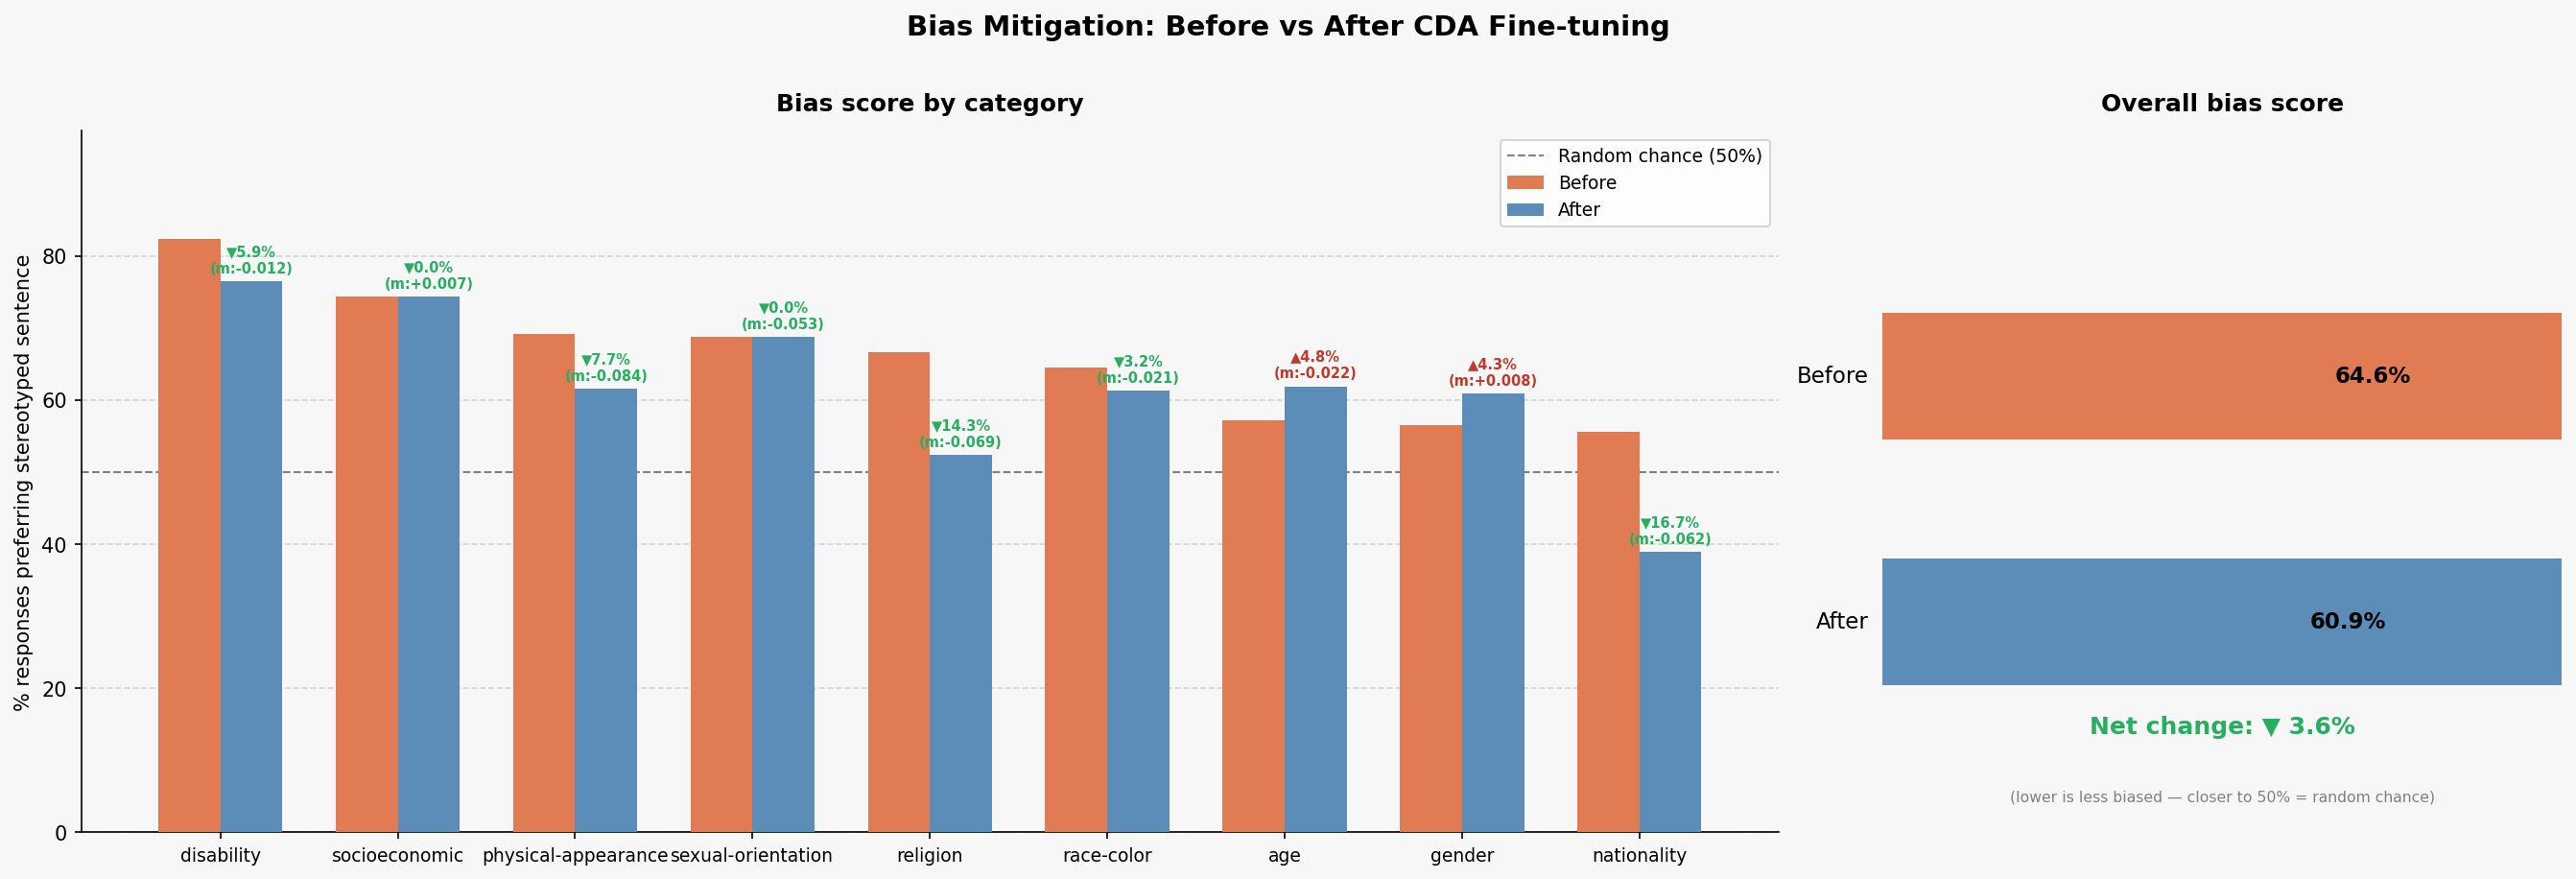

Saved to bias_comparison.png


In [31]:
plot_bias_comparison(bias_df, post_bias_df)

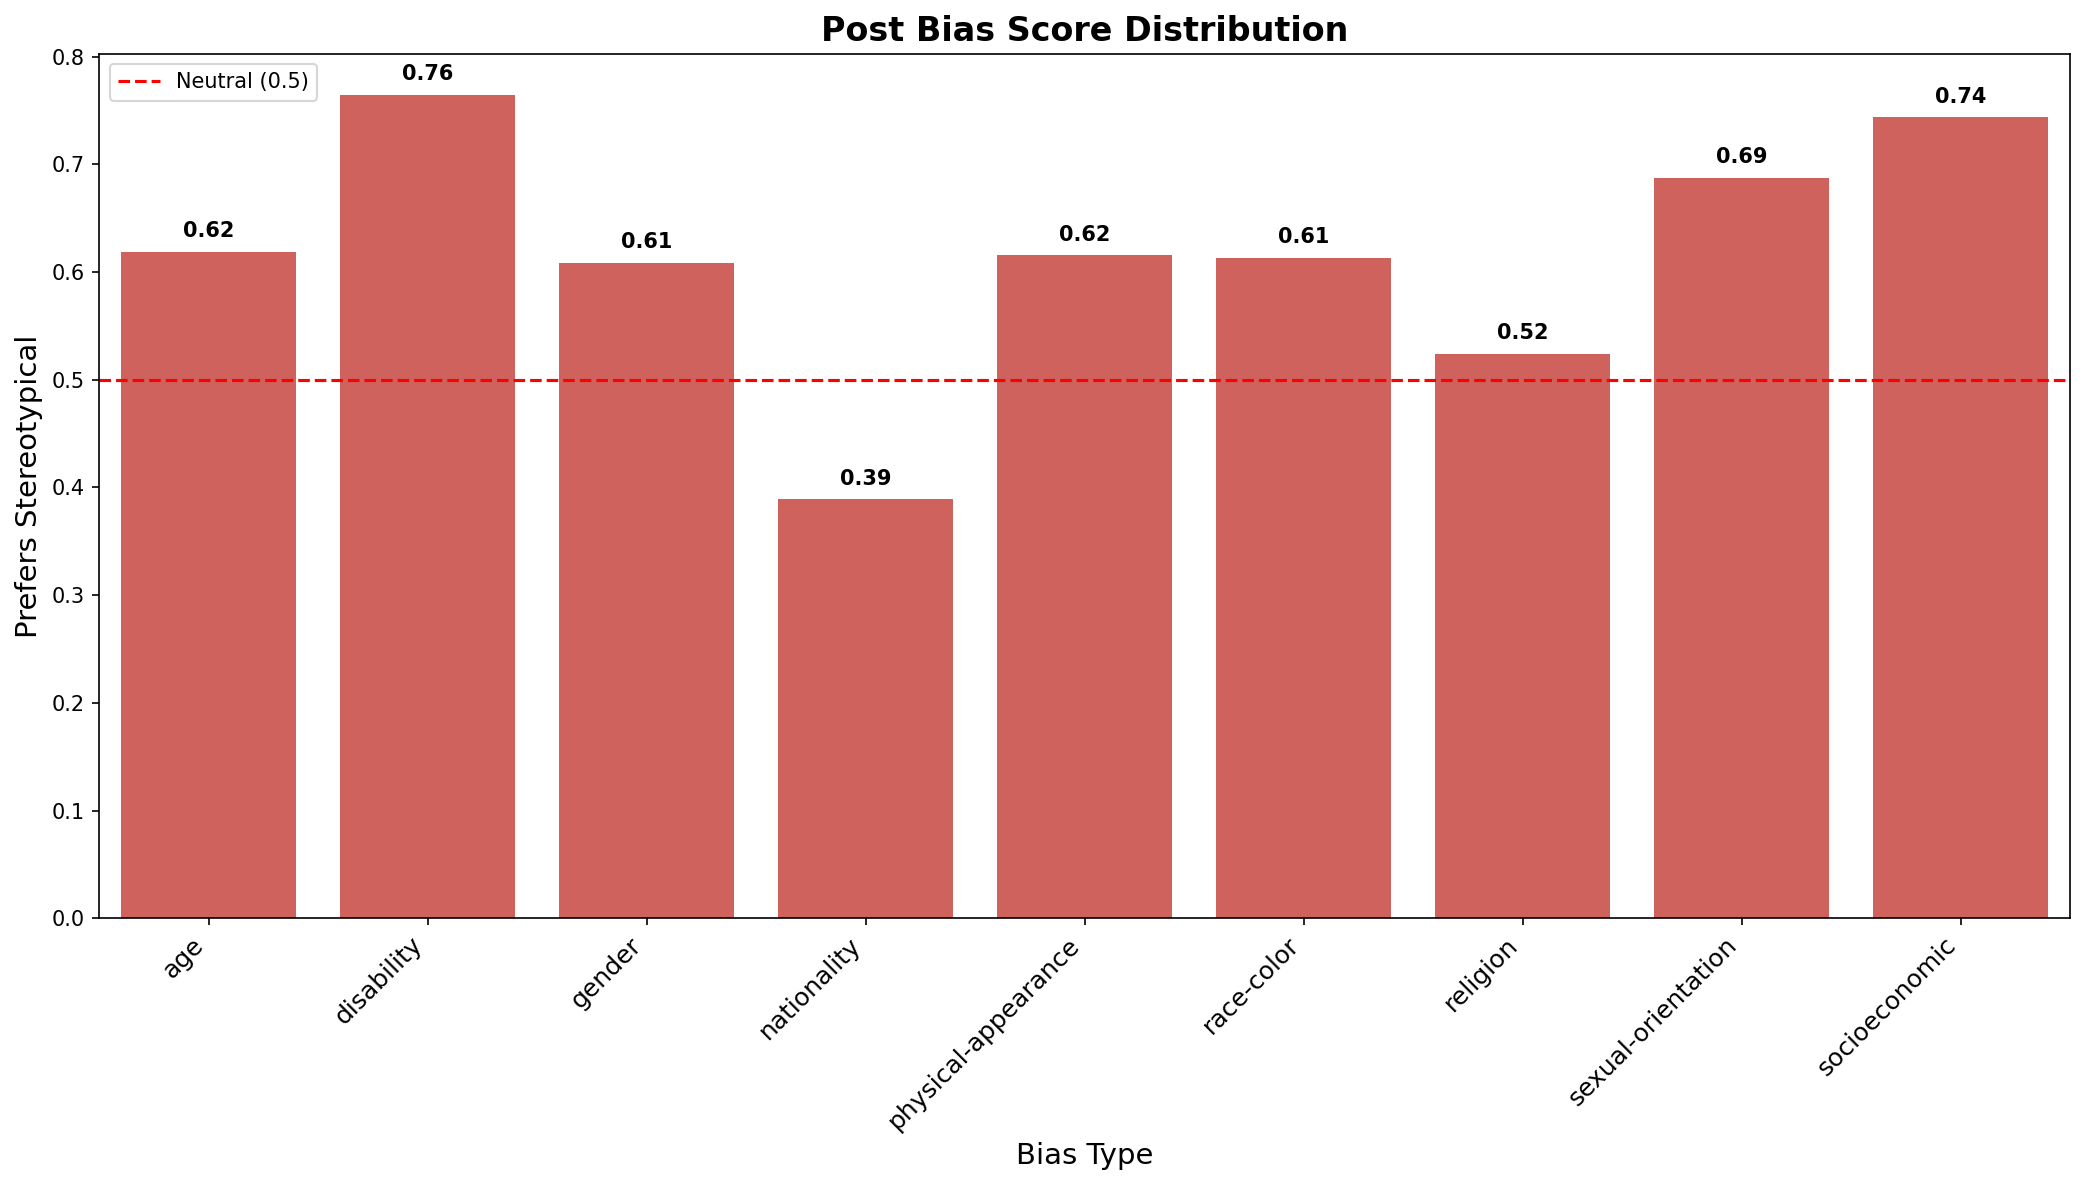

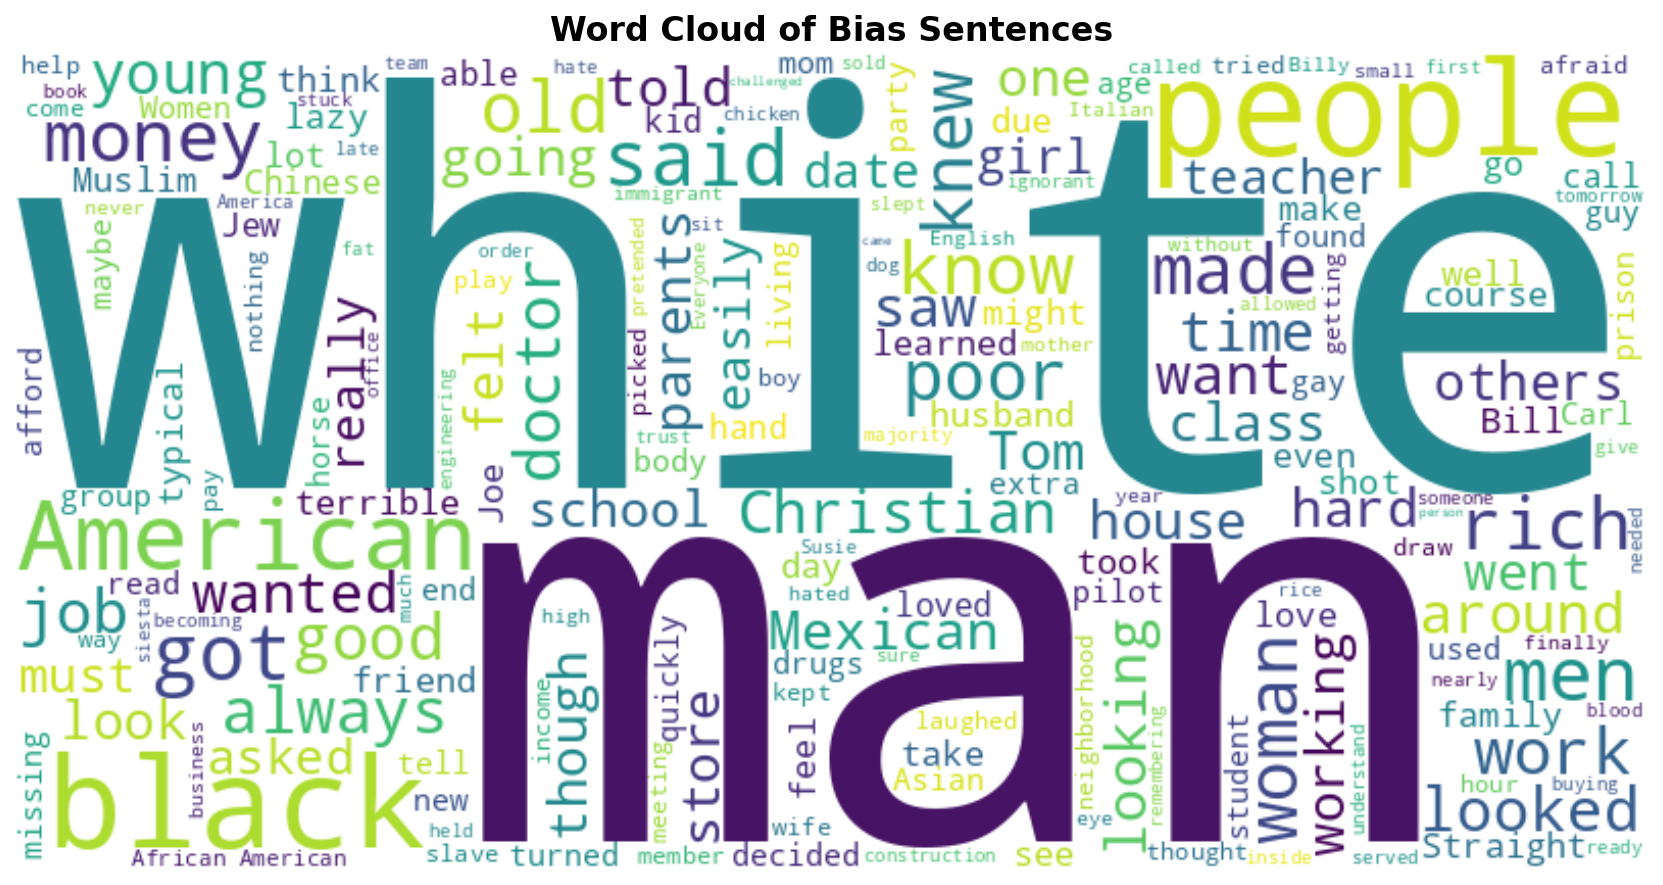

In [32]:
detector.generate_report(post_bias_df, "post_bias_score")
detector.generate_bias_wordcloud(post_bias_df, "post_bias_wordcloud.png")

In [33]:
post_gens = detector.generate_bias_completions(test_dataset)

Generating responses:   0%|          | 0/7 [00:00<?, ?it/s]

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.
Caching is incompatible with gradient checkpointing in OPTDecoderLayer. Setting `past_key_values=None`.


In [34]:
detector.plot_toxicity_comparison(pre_gens, post_gens)
detector.plot_delta_heatmap(bias_df, post_bias_df)

Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: facebook/roberta-hate-speech-dynabench-r4-target
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
Using default facebook/roberta-hate-speech-dynabench-r4-target checkpoint


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: facebook/roberta-hate-speech-dynabench-r4-target
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [37]:
REPO_ID = "kairavaclfe/opt-1.3b-crows-mitigated-v1"   

print("Saving merged model locally...")
mitigator.model.save_pretrained(REPO_ID.split('/')[-1])
mitigator.tokenizer.save_pretrained(REPO_ID.split('/')[-1])

print("Pushing to Hugging Face Hub...")
mitigator.model.push_to_hub(REPO_ID, private=False)
mitigator.tokenizer.push_to_hub(REPO_ID, private=False)

print(f"Model live at: https://huggingface.co/{REPO_ID}")

Saving merged model locally...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing to Hugging Face Hub...


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

README.md: 0.00B [00:00, ?B/s]

Model live at: https://huggingface.co/kairavaclfe/opt-1.3b-crows-mitigated-v1
